# Face recognition using SVM and kernel trick

# Dataset description

This assignment asks you to build a classifier trained on face images. First, let's load the required dataset and see what it is. 

The table contains "straightened" representations of images of people's faces.

Initially, each image is a matrix of size $62 \times 47$ whose values are presumably normalized to a range $[0, 1]$ from the range $[0, 255] \cap \mathbb Z$. The values themselves are responsible for the intensity of the pixel: the larger the value, the lighter the pixel.

Note, from the image (or, what is the same thing, matrix) of size $62 \times 47$ we get a vector of $2914 = 62 \cdot 47$ length.

The column <code>label</code> is responsible for the name of the person depicted in the picture.

In [1]:
import os
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv(os.path.join('data', 'persons_pics_train.csv'))

In [3]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,2905,2906,2907,2908,2909,2910,2911,2912,2913,label
0,0.379085,0.312418,0.352941,0.445752,0.466667,0.473203,0.484967,0.513725,0.545098,0.571242,...,0.597386,0.620915,0.732026,0.852288,0.921569,0.937255,0.941176,0.950327,0.946405,John Ashcroft
1,0.450980,0.466667,0.512418,0.509804,0.450980,0.458824,0.516340,0.571242,0.607843,0.618301,...,0.430065,0.453595,0.679739,0.934640,0.985621,0.981699,0.963399,0.938562,0.874510,Ariel Sharon
2,0.589542,0.614379,0.688889,0.729412,0.738562,0.775163,0.789543,0.806536,0.820915,0.837908,...,0.733333,0.854902,0.937255,0.624837,0.128105,0.082353,0.107190,0.095425,0.100654,Colin Powell
3,0.390850,0.432680,0.499346,0.562091,0.597386,0.644444,0.670588,0.650980,0.637908,0.639216,...,0.713726,0.898039,0.968627,0.959477,0.832680,0.443137,0.266667,0.303268,0.313725,Jean Chretien
4,0.645752,0.626144,0.605229,0.585621,0.602614,0.664052,0.701961,0.709804,0.733333,0.771242,...,0.115033,0.129412,0.132026,0.129412,0.155556,0.171242,0.167320,0.176471,0.183007,Colin Powell


In [4]:
df.shape

(1326, 2915)

Let's make sure that we actually see images of people's faces. Let's take the first $15$ rows from the initial dataframe and build the images corresponding to them.

In [5]:
import matplotlib.pyplot as plt

def get_img_by_row(row):
  return row.drop('label').astype(float).to_numpy().reshape(62,47), row['label']

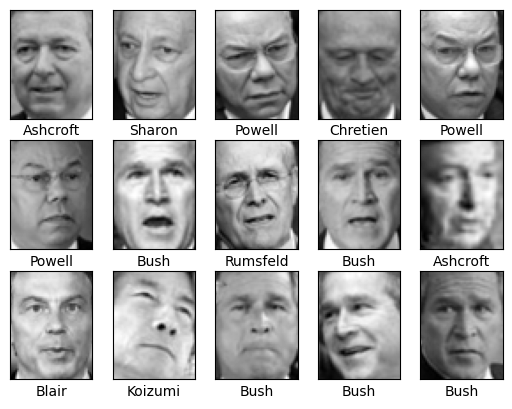

In [6]:
fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
    img, lbl = get_img_by_row(df.iloc[i])
    axi.imshow(img, cmap='gray')
    axi.set(xticks=[], yticks=[], xlabel=lbl.split()[-1])
plt.savefig('persons_pics_img_for_description.png', dpi=300, bbox_inches='tight')    

Larger

(-0.5, 46.5, 61.5, -0.5)

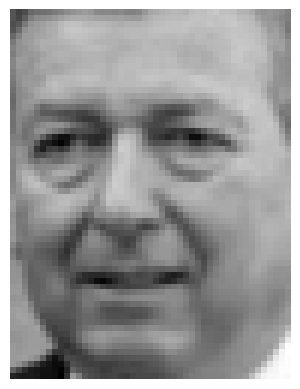

In [7]:
plt.imshow(df.iloc[0].drop('label').astype(float).to_numpy().reshape(62,47), cmap='gray')
plt.axis('off')

# A bit of mischief

Determine the number of different people whose pictures are contained in the dataset.

In [8]:
df.label.unique()

array(['John Ashcroft', 'Ariel Sharon', 'Colin Powell', 'Jean Chretien',
       'George W Bush', 'Donald Rumsfeld', 'Tony Blair',
       'Junichiro Koizumi', 'Gerhard Schroeder', 'Hugo Chavez',
       'Serena Williams', 'Jacques Chirac'], dtype=object)

In [9]:
df.label.nunique()

12

Construct a histogram of the distribution of objects by class and calculate the proportion of objects in each class.

In [10]:
df.label.value_counts() / df.shape[0]

label
George W Bush        0.340121
Colin Powell         0.151584
Tony Blair           0.092006
Donald Rumsfeld      0.077677
Gerhard Schroeder    0.070136
Ariel Sharon         0.049020
Hugo Chavez          0.045249
Junichiro Koizumi    0.038462
Jean Chretien        0.035445
John Ashcroft        0.033937
Serena Williams      0.033183
Jacques Chirac       0.033183
Name: count, dtype: float64

Based on the available data, match each person with one vector whose coordinates are the average of the corresponding coordinates of all vectors identified with that person.

In [11]:
df_avg = df.groupby(['label'], as_index=False).mean()

In [12]:
df_avg.head()

,label,0,1,2,3,4,5,6,7,8,...,2904,2905,2906,2907,2908,2909,2910,2911,2912,2913
0,Ariel Sharon,0.501398,0.514811,0.532609,0.551714,0.569754,0.577456,0.581820,0.591835,0.604465,...,0.396400,0.433947,0.478291,0.519920,0.532549,0.515656,0.498220,0.486657,0.466928,0.437687
1,Colin Powell,0.433512,0.441147,0.456248,0.471947,0.486730,0.513732,0.545157,0.566514,0.581556,...,0.437869,0.471798,0.512067,0.534615,0.532176,0.510006,0.477586,0.448119,0.410659,0.379605
2,Donald Rumsfeld,0.404810,0.417260,0.442731,0.474028,0.507938,0.541659,0.560112,0.571838,0.585773,...,0.494917,0.546837,0.562307,0.558627,0.549426,0.525947,0.500603,0.475550,0.431893,0.391738
3,George W Bush,0.348179,0.360263,0.381659,0.416669,0.457154,0.488335,0.515398,0.536075,0.551153,...,0.385818,0.414092,0.441074,0.461325,0.470275,0.459067,0.447653,0.430523,0.399620,0.376584
4,Gerhard Schroeder,0.210162,0.228210,0.268255,0.328344,0.389332,0.447115,0.495003,0.527655,0.549441,...,0.414969,0.430937,0.469281,0.494596,0.496718,0.482550,0.442252,0.428477,0.426875,0.411118


Enter the coordinate with index $0$ of the average vector corresponding to the person in your individual assignment.

In [13]:
df_avg.loc[df_avg.label == 'Hugo Chavez', '0']

5    0.206885
Name: 0, dtype: float64

Using the average vectors, construct pictures of all the people in the dataset.

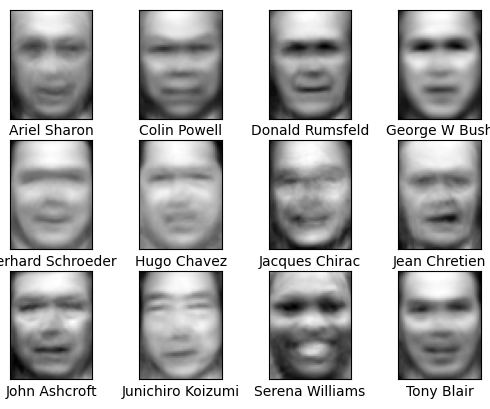

In [14]:
fig, ax = plt.subplots(3, 4)
for i, axi in enumerate(ax.flat):
    img, lbl = get_img_by_row(df_avg.iloc[i])
    axi.imshow(img, cmap='gray')
    axi.set(xticks=[], yticks=[], xlabel=lbl)
plt.savefig('persons_pics_img_for_description.png', dpi=300, bbox_inches='tight')    

The so-called [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity) is often used as a measure of the "similarity" of two objects. It should not be confused with cosine distance.

Construct a similarity matrix of objects based on their averaged vectors. We recommend using a heat map for visualization, e.g. [from the seaborn library](https://seaborn.pydata.org/generated/seaborn.heatmap.html).

In [15]:
import seaborn as sns

In [16]:
cos_sim = lambda a, b: np.dot(a, b) / ((np.sum(a ** 2) ** 0.5) * (np.sum(b ** 2) ** 0.5))

In [17]:
cos_res = pd.DataFrame()
for i in df_avg.label.unique():
    temp_res = []
    temp_i = df_avg.loc[df_avg.label == i].values[0][1:]
    for j in df_avg.label.unique():
        temp_j = df_avg.loc[df_avg.label == j].values[0][1:]
        temp_res.append(cos_sim(temp_i, temp_j))
    cos_res = pd.concat([cos_res, pd.DataFrame(data=[[i] + temp_res], columns=['label'] + df_avg.label.unique().tolist())], axis=0)
cos_res = cos_res.set_index('label')

<Axes: ylabel='label'>

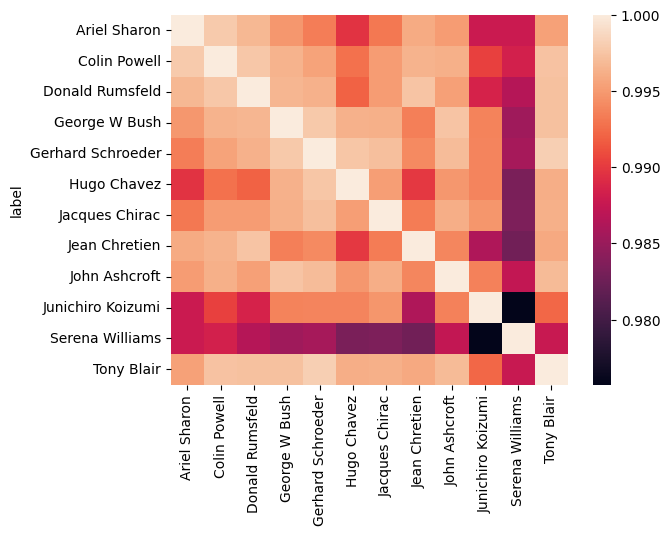

In [18]:
sns.heatmap(cos_res)

Determine the cosine similarity for a pair of people from your individual assignment based on their corresponding "average" vectors.

In [19]:
cos_res['Gerhard Schroeder'].loc['Serena Williams']

0.9857477316972306

# Построение модели

Use <code>train_test_split()</code> to split the dataset into training and test samples with the parameters from your individual assignment. Use stratification by column <code>label</code>.

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
stratify_arr = df.label.values
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=['label']),
    df.label.values,
    test_size=0.2,
    random_state=15,
    stratify=stratify_arr
)

## First approximation: a basic SVM classifier with a linear kernel

Train the <code>SVC()</code> model on the training dataset with the parameters from your individual assignment.

In [22]:
from sklearn.svm import SVC

In [23]:
svc = SVC(kernel='linear', random_state=15)
svc.fit(X_train, y_train)

SVC(kernel='linear', random_state=15)

Evaluate the model on test dataset. Compute <code>f1_score(average='weighted')</code>.

In [24]:
from sklearn.metrics import f1_score

In [25]:
f1_score(y_test, svc.predict(X_test), average='weighted')

0.8027923282543553

Overall, a pretty good result, but it makes sense to try to tweak the parameters.

## Selection of hyperparameters

Using <code>GridSearchCV()</code>, perform a hyperparameter selection based on the values from your individual assignment. Observe the training time of the models.

In [26]:
from sklearn.model_selection import GridSearchCV

In [27]:
tuned_parameters = [{
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': [1e-3, 1e-4],
    'C': [1, 10, 100, 1000],
    'class_weight':[None, 'balanced'],
    'random_state':[15]
}]
cv = GridSearchCV(SVC(), tuned_parameters, refit=True, verbose=3)
cv.fit(X_train, y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV 1/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=15;, score=0.759 total time=   0.3s
[CV 2/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=15;, score=0.764 total time=   0.3s
[CV 3/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=15;, score=0.778 total time=   0.3s
[CV 4/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=15;, score=0.797 total time=   0.3s
[CV 5/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=15;, score=0.774 total time=   0.3s
[CV 1/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=15;, score=0.368 total time=   0.4s
[CV 2/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=15;, score=0.358 total time=   0.4s
[CV 3/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=15;, score=0.358 total time=   0.4s
[CV 4/5] END C=1, class_weight=N

GridSearchCV(estimator=SVC(),
             param_grid=[{'C': [1, 10, 100, 1000],
                          'class_weight': [None, 'balanced'],
                          'gamma': [0.001, 0.0001],
                          'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                          'random_state': [15]}],
             verbose=3)

Determine the parameters of the <b>best</b> learned model.

In [28]:
cv.best_params_

{'C': 100,
 'class_weight': 'balanced',
 'gamma': 0.001,
 'kernel': 'rbf',
 'random_state': 15}

Perform prediction for the test dataset using the best model obtained. Compute <code>f1_score(average='weighted')</code>.

In [29]:
f1_score(y_test, cv.predict(X_test), average='weighted')

0.7955559012883923

## Dimensionality reduction

Learning took a long time. It makes sense to test what happens if you reduce the dimensionality of the input dataset, e.g. by using <code>PCA</code>. Train the <code>PCA(svd_solver='full')</code> model on the training dataset and determine the minimum number of components required for the explained variance ratio to be greater than <code>0.95</code>.

In [30]:
from sklearn.decomposition import PCA

In [31]:
pca = PCA(svd_solver='full')
pca.fit(X_train)

PCA(svd_solver='full')

In [32]:
pca.explained_variance_ratio_[:173].sum()

0.9502042111384146

Re-train the <code>PCA(svd_solver='full')</code> model on the training dataset using the resulting number of principal components. Apply the resulting transformation to the training and test datasets.

In [33]:
pca = PCA(svd_solver='full', n_components=173)
pca.fit(X_train)

PCA(n_components=173, svd_solver='full')

In [34]:
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

For the data obtained after <code>PCA</code>, similarly to what was done earlier, i.e., using the <code>GridSearchCV()</code>, select hyperparameters from the ranges specified in your individual assignment. Pay special attention to model training time.

In [35]:
tuned_parameters = [{
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': [1e-3, 1e-4],
    'C': [1, 10, 100, 1000],
    'class_weight':[None, 'balanced'],
    'random_state':[15]
}]
cv = GridSearchCV(SVC(), tuned_parameters, refit=True, verbose=3, n_jobs=-1)
cv.fit(X_train, y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid=[{'C': [1, 10, 100, 1000],
                          'class_weight': [None, 'balanced'],
                          'gamma': [0.001, 0.0001],
                          'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                          'random_state': [15]}],
             verbose=3)

Determine the parameters of the <b>best</b> model obtained.

In [36]:
cv.best_params_

{'C': 1000,
 'class_weight': 'balanced',
 'gamma': 0.0001,
 'kernel': 'rbf',
 'random_state': 15}

Perform prediction for the test dataset using the best model obtained. Compute <code>f1_score(average='weighted')</code>.

In [37]:
f1_score(y_test, cv.predict(X_test), average='weighted')

0.7972071968887497

It can be seen that the quality of the model has changed only slightly, while the training time has decreased significantly.